# Skin Conditions Model
This model is the model that used to classify user's skin conditions and have an output of multi-label class from 3 possible class (acne,eye_bags, redness)

## Import Libraries, Mobilenet, and Env File

In [3]:
import tensorflow as tf
import pandas as pd
import os
import matplotlib.pyplot as plt
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import multilabel_confusion_matrix, classification_report

In [4]:
# Importing Env File
from dotenv import load_dotenv

load_dotenv()
datasets_path = os.getenv('DATASET_PATH_CONDITIONS')

In [5]:
# Importing MobileNetV2 Model With ImagNet Weight Without The Top Layer
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

In [6]:
# Membekukan semua lapisan dari model MobileNetV2
for layer in base_model.layers:
    layer.trainable = False

In [7]:
# Fine-tuning: Membuka beberapa lapisan terakhir dari MobileNetV2
for layer in base_model.layers[-20:]:  # Mengatur lebih banyak lapisan terakhir dapat dilatih
    layer.trainable = True

## Import Dataset

In [ ]:
import tensorflow as tf
import tensorflow_datasets as tfds
import pandas as pd
import os
from sklearn.model_selection import train_test_split

class SkinConditionsDataset(tfds.core.GeneratorBasedBuilder):
    """DatasetBuilder for skin condition detection."""

    VERSION = tfds.core.Version('1.0.0')
    MANUAL_DOWNLOAD_INSTRUCTIONS = "Please ensure the skin type dataset is downloaded and located at the right path (look at env file)"

    def _info(self):
        return tfds.core.DatasetInfo(
            builder=self,
            description=("Dataset for skin conditions classification with 3 labels: acne, eye_bags ,redness"),
            features=tfds.features.FeaturesDict({
                'image': tfds.features.Image(shape=(224, 224, 3)),
                'label': tfds.features.Tensor(shape=(3,), dtype=tf.float32),
            }),
            supervised_keys=('image', 'label'),
        )

    def _split_generators(self, dl_manager):
        # Mengambil data dari path yang telah diinstruksikan
        path = dl_manager.manual_dir
        
        # Membaca semua gambar dan label
        all_data = []
        for category in ['acne', 'eye_bags', 'redness']:
            category_path = os.path.join(path, category)
            for filename in os.listdir(category_path):
                all_data.append((filename, category))

        # Membuat DataFrame
        df = pd.DataFrame(all_data, columns=['filename', 'label'])

        # Menyeimbangkan dataset dengan mengambil 500 sampel dari setiap kelas
        # balanced_df = df.groupby('label').apply(lambda x: x.sample(n=500, random_state=42)).reset_index(drop=True)

        # Membagi data menjadi train, val, dan test
        # train_df, test_df = train_test_split(balanced_df, test_size=0.2, random_state=42)
        train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)
        train_df, val_df = train_test_split(train_df, test_size=0.25, random_state=42)  # 0.25 dari train untuk validasi

        return {
            'train': self._generate_examples(train_df, path),
            'val': self._generate_examples(val_df, path),
            'test': self._generate_examples(test_df, path),
        }

    def _generate_examples(self, dataframe, base_path):
        """Yields examples."""
        label_map = {
            'acne': [1, 0, 0],
            'eye_bags': [0, 1, 0],
            'redness': [0, 0, 1],
        }
        for _, row in dataframe.iterrows():
            image_path = os.path.join(base_path, row['label'], row['filename'])
            unique_key = f"{row['label']}_{row['filename']}"  # Unique Key To Avoid Duplicates
            print(f"Accessing: {image_path}")  # Debugging print statement
            label = label_map[row['label']]
            yield unique_key, {  # Using Unique Key
                'image': image_path,
                'label': label,
            }


builder = SkinConditionsDataset(data_dir=datasets_path)
builder.download_and_prepare()

# Memuat dataset
ds_train = builder.as_dataset(split='train')
ds_val = builder.as_dataset(split='val')
ds_test = builder.as_dataset(split='test')

## Import Data and Data Augmentation

In [8]:
import tensorflow as tf
import tensorflow_datasets as tfds
import pandas as pd
import os
from sklearn.model_selection import train_test_split
import random

class SkinConditionsDataset(tfds.core.GeneratorBasedBuilder):
    """DatasetBuilder for skin condition detection."""

    VERSION = tfds.core.Version('1.0.0')
    MANUAL_DOWNLOAD_INSTRUCTIONS = "Please ensure the skin type dataset is downloaded and located at the right path (look at env file)"

    def _info(self):
        return tfds.core.DatasetInfo(
            builder=self,
            description=("Dataset for skin conditions classification with 3 labels: acne, eye_bags ,redness"),
            features=tfds.features.FeaturesDict({
                'image': tfds.features.Image(shape=(224, 224, 3)),
                'label': tfds.features.Tensor(shape=(3,), dtype=tf.float32),
            }),
            supervised_keys=('image', 'label'),
        )

    def _split_generators(self, dl_manager):
        path = dl_manager.manual_dir
        
        # Membaca semua gambar dan label
        all_data = []
        for category in ['acne', 'eye_bags', 'redness']:
            category_path = os.path.join(path, category)
            for filename in os.listdir(category_path):
                all_data.append((filename, category))

        # Membuat DataFrame
        df = pd.DataFrame(all_data, columns=['filename', 'label'])

        # Membagi data menjadi train, val, dan test
        train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)
        train_df, val_df = train_test_split(train_df, test_size=0.25, random_state=42)  # 0.25 dari train untuk validasi

        return {
            'train': self._generate_examples(train_df, path),
            'val': self._generate_examples(val_df, path),
            'test': self._generate_examples(test_df, path),
        }

    def _generate_examples(self, dataframe, base_path):
        label_map = {
            'acne': [1, 0, 0],
            'eye_bags': [0, 1, 0],
            'redness': [0, 0, 1],
        }
        images_labels = []

        # Load images and their labels
        for _, row in dataframe.iterrows():
            image_path = os.path.join(base_path, row['label'], row['filename'])
            image = tf.io.read_file(image_path)  # Membaca file gambar
            image = tf.io.decode_image(image, channels=3)  # Decode gambar ke tensor
            image = tf.image.resize(image, (224, 224))  # Ubah ukuran gambar
            image = tf.cast(image, tf.uint8)  # Konversi tipe data ke uint8
            label = tf.cast(label_map[row['label']], tf.float32)  # Cast to float32
            images_labels.append((image, label))  # Tambahkan ke list

        # Generate standard examples
        for i, (image, label) in enumerate(images_labels):
            yield f"{label.numpy()}_{i}", {  # Mengubah label menjadi NumPy array sebelum yield
                'image': image.numpy(),
                'label': label.numpy(),  # Pastikan label adalah NumPy array
            }

        # Generate overlay examples
        for i in range(0, len(images_labels), 3):  # Ambil setiap 3 gambar
            # Ambil salah satu gambar dari 3 gambar untuk di-overlay
            selected_images = images_labels[i:i+3]  # Mengambil 3 gambar berturut-turut
            if len(selected_images) < 3:
                continue  # Skip jika tidak ada cukup gambar dalam kelompok
            
            # Pilih satu gambar acak untuk di-overlay dengan dua lainnya
            random.shuffle(selected_images)  # Acak gambar dalam kelompok tiga
            image1, label1 = selected_images[0]  # Gambar pertama yang dipilih
            image2, label2 = selected_images[1]  # Gambar kedua yang dipilih

            # Buat overlay hanya dari dua gambar yang dipilih
            combined_image, combined_label = self.overlay_two_data(image1, label1, image2, label2)
            combined_image = tf.cast(combined_image, tf.uint8)  # Pastikan konversi ke uint8 untuk overlay

            # Buat key unik untuk overlay
            unique_key = f"overlay_{i}_{i+1}"

            # Yield contoh baru untuk dataset
            yield unique_key, {
                'image': combined_image.numpy(),
                'label': combined_label.numpy(),  # Pastikan label adalah NumPy array
            }

            # Loop kedua untuk menghasilkan overlay tiga kelas
            if len(selected_images) == 3:  # Pastikan ada tepat 3 gambar
                image3, label3 = selected_images[2]  # Ambil gambar ketiga
                # Gabungkan tiga gambar dan label
                combined_image, combined_label = self.overlay_three_data(image1, label1, image2, label2, image3, label3)
                combined_image = tf.cast(combined_image, tf.uint8)  # Pastikan konversi ke uint8 untuk overlay

                # Buat key unik untuk overlay tiga kelas
                unique_key = f"overlay_three_{i}_{i+1}_{i+2}"

                # Yield contoh baru untuk dataset (overlay tiga kelas)
                yield unique_key, {
                    'image': combined_image.numpy(),
                    'label': combined_label.numpy(),  # Pastikan label adalah NumPy array
                }

    # Fungsi untuk menggabungkan dua gambar
    def overlay_two_images(self, image1, image2, alpha=0.5):
        # Resize kedua gambar ke ukuran yang sama
        image1 = tf.image.resize(image1, (224, 224))
        image2 = tf.image.resize(image2, (224, 224))

        # Gabungkan gambar dengan alpha untuk mengatur seberapa banyak kontribusi dari setiap gambar
        combined_image = (image1 * alpha) + (image2 * alpha)

        return combined_image

    # Fungsi untuk menggabungkan tiga gambar
    def overlay_three_images(self, image1, image2, image3, alpha=0.33):
        # Resize semua gambar ke ukuran yang sama
        image1 = tf.image.resize(image1, (224, 224))
        image2 = tf.image.resize(image2, (224, 224))
        image3 = tf.image.resize(image3, (224, 224))

        # Gabungkan gambar dengan alpha untuk mengatur seberapa banyak kontribusi dari setiap gambar
        combined_image = (image1 * alpha) + (image2 * alpha) + (image3 * alpha)

        return combined_image

    # Fungsi untuk overlay dua data (label juga digabung)
    def overlay_two_data(self, image1, label1, image2, label2):
        combined_image = self.overlay_two_images(image1, image2)
        # Gabungkan label dengan mengambil nilai maksimum untuk setiap kelas
        combined_label = tf.maximum(label1, label2)
        return combined_image, combined_label

    # Fungsi untuk overlay tiga data (label juga digabung)
    def overlay_three_data(self, image1, label1, image2, label2, image3, label3):
        combined_image = self.overlay_three_images(image1, image2, image3)
        # Gabungkan label dengan mengambil nilai maksimum untuk setiap kelas
        combined_label = tf.maximum(tf.maximum(label1, label2), label3)
        return combined_image, combined_label


# Use the updated dataset class
builder = SkinConditionsDataset(data_dir=datasets_path)
builder.download_and_prepare()

# Memuat dataset
ds_train = builder.as_dataset(split='train')
ds_val = builder.as_dataset(split='val')
ds_test = builder.as_dataset(split='test')

In [9]:
# Memuat dataset yang sudah diproses
ds_train = tfds.load('skin_conditions_dataset', split='train', data_dir=datasets_path)
ds_val = tfds.load('skin_conditions_dataset', split='val', data_dir=datasets_path)
ds_test = tfds.load('skin_conditions_dataset', split='test', data_dir=datasets_path)

In [10]:
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

# Fungsi untuk memastikan data tersusun sebagai pasangan (image, label)
def preprocess(data):
    image = data['image']
    label = data['label']
    return image, label

def preprocess_image(image, label):
    image = tf.image.resize(image, (224, 224))
    image = preprocess_input(image)  # Preprocessing sesuai MobileNet
    return image, label

ds_train = ds_train.map(preprocess, num_parallel_calls=tf.data.experimental.AUTOTUNE)
ds_val = ds_val.map(preprocess, num_parallel_calls=tf.data.experimental.AUTOTUNE)
ds_test = ds_test.map(preprocess, num_parallel_calls=tf.data.experimental.AUTOTUNE)

ds_train = ds_train.map(preprocess_image)
ds_val = ds_val.map(preprocess_image)
ds_test = ds_test.map(preprocess_image)

ds_train = ds_train.batch(32).prefetch(tf.data.AUTOTUNE)
ds_val = ds_val.batch(32).prefetch(tf.data.AUTOTUNE)
ds_test = ds_test.batch(32).prefetch(tf.data.AUTOTUNE)

In [11]:
# Hitung jumlah data dalam ds_train
num_samples = sum(1 for _ in ds_train)
# num_samples = sum(1 for _ in ds_train.unbatch())

print(f"Jumlah gambar dan label dalam ds_train: {num_samples}")


Jumlah gambar dan label dalam ds_train: 19


In [12]:
# Filter dan tampilkan label dengan nilai [1. 0. 0.]
for i, example in enumerate(ds_train):
    label = example['label'].numpy()  # Ambil label sebagai numpy array
    if (label == [1, 1, 0]).all():    
        print(f"Label {i + 1}: {label}")

TypeError: tuple indices must be integers or slices, not str

In [40]:
# Filter dan tampilkan label dengan nilai [1. 0. 0.]
for i, example in enumerate(ds_val):
    label = example['label'].numpy()  # Ambil label sebagai numpy array
    if (label == [1, 1, 0]).all():    
        print(f"Label {i + 1}: {label}")

Label 16: [1. 1. 0.]
Label 21: [1. 1. 0.]
Label 31: [1. 1. 0.]
Label 66: [1. 1. 0.]
Label 67: [1. 1. 0.]
Label 70: [1. 1. 0.]
Label 79: [1. 1. 0.]
Label 82: [1. 1. 0.]
Label 92: [1. 1. 0.]
Label 96: [1. 1. 0.]
Label 98: [1. 1. 0.]
Label 119: [1. 1. 0.]
Label 123: [1. 1. 0.]
Label 149: [1. 1. 0.]
Label 152: [1. 1. 0.]
Label 163: [1. 1. 0.]


In [37]:
# Filter dan tampilkan label dengan nilai [1. 0. 0.]
for i, example in enumerate(ds_test):
    label = example['label'].numpy()  # Ambil label sebagai numpy array
    if (label == [1, 0, 1]).all():    
        print(f"Label {i + 1}: {label}")

Label 1: [1. 0. 1.]
Label 6: [1. 0. 1.]
Label 13: [1. 0. 1.]
Label 17: [1. 0. 1.]
Label 21: [1. 0. 1.]
Label 24: [1. 0. 1.]
Label 32: [1. 0. 1.]
Label 33: [1. 0. 1.]
Label 41: [1. 0. 1.]
Label 42: [1. 0. 1.]
Label 46: [1. 0. 1.]
Label 68: [1. 0. 1.]
Label 71: [1. 0. 1.]
Label 97: [1. 0. 1.]
Label 107: [1. 0. 1.]
Label 108: [1. 0. 1.]
Label 115: [1. 0. 1.]
Label 119: [1. 0. 1.]
Label 135: [1. 0. 1.]
Label 138: [1. 0. 1.]
Label 141: [1. 0. 1.]
Label 147: [1. 0. 1.]
Label 157: [1. 0. 1.]
Label 166: [1. 0. 1.]
Label 191: [1. 0. 1.]


In [19]:
# import matplotlib.pyplot as plt
# import tensorflow as tf

# # Fungsi untuk menampilkan gambar
# def show_image(image):
#     # Konversi gambar tensor ke numpy array dan tampilkan dengan matplotlib
#     image = image.numpy()  # Ubah tensor menjadi numpy array
#     plt.imshow(image)
#     plt.axis('off')  # Nonaktifkan axis
#     plt.show()

# # Fungsi untuk menampilkan beberapa gambar
# def show_images_from_dataset(dataset, num_images=5):
#     for i, data in enumerate(dataset.take(num_images)):  # Ambil beberapa gambar pertama dari dataset
#         image = data['image']
#         # Tampilkan gambar
#         show_image(image)

# # Menampilkan gambar pertama dari ds_train
# show_images_from_dataset(ds_train, num_images=5)


In [13]:
from tensorflow.keras.layers import Dropout, BatchNormalization, GlobalAveragePooling2D, Dense, ReLU
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2

# Menambahkan lapisan kustom di atas MobileNetV2
x = base_model.output
x = GlobalAveragePooling2D()(x) 
# x = Dense(1024, kernel_regularizer=l2(0.01))(x)
# x = BatchNormalization()(x)
# x = ReLU()(x)  # ReLU activation setelah batch normalization
# x = Dropout(0.4)(x) 
x = Dense(512, kernel_regularizer=l2(0.01))(x)
x = BatchNormalization()(x)
x = ReLU()(x)  # ReLU activation setelah batch normalization
x = Dropout(0.3)(x)
outputs = Dense(3, activation='sigmoid', kernel_regularizer=l2(0.01))(x)  # Menggunakan sigmoid untuk multi-label classification

# Membuat model akhir
model = Model(inputs=base_model.input, outputs=outputs)

# Menyesuaikan optimizer dan learning rate 
optimizer = tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.9) 
# Compiling the model 
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

In [14]:
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ReduceLROnPlateau

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.2, patience=5, 
    min_lr=0.001)

early_stopping = EarlyStopping(
    monitor='val_loss', 
    patience=6,          
    restore_best_weights=True
)

In [15]:
for image, label in ds_train.take(1):
    print(image.shape, label.shape)  # Pastikan gambar memiliki shape (32, 224, 224, 3)

(32, 224, 224, 3) (32, 3)


## Train Model

Epoch 1/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 13s 470ms/step - accuracy: 0.4542 - loss: 8.0729 - val_accuracy: 0.6410 - val_loss: 7.9070
Epoch 2/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 11s 578ms/step - accuracy: 0.7240 - loss: 7.7364 - val_accuracy: 0.7128 - val_loss: 7.7892
Epoch 3/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 11s 593ms/step - accuracy: 0.8085 - loss: 7.5674 - val_accuracy: 0.7385 - val_loss: 7.7139
Epoch 4/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 11s 592ms/step - accuracy: 0.8663 - loss: 7.4485 - val_accuracy: 0.7436 - val_loss: 7.6441
Epoch 5/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 11s 597ms/step - accuracy: 0.8671 - loss: 7.3506 - val_accuracy: 0.7641 - val_loss: 7.5777
Epoch 6/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 11s 573ms/step - accuracy: 0.8534 - loss: 7.2660 - val_accuracy: 0.7487 - val_loss: 7.5117
Epoch 7/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 11s 583ms/step - accuracy: 0.8619 - loss: 7.1967 - val_accuracy: 0.7538 - val_loss: 7.4480
Epoch 8/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 11s 572ms/step - accuracy: 0.8612 - loss: 7.1273 - val_accu

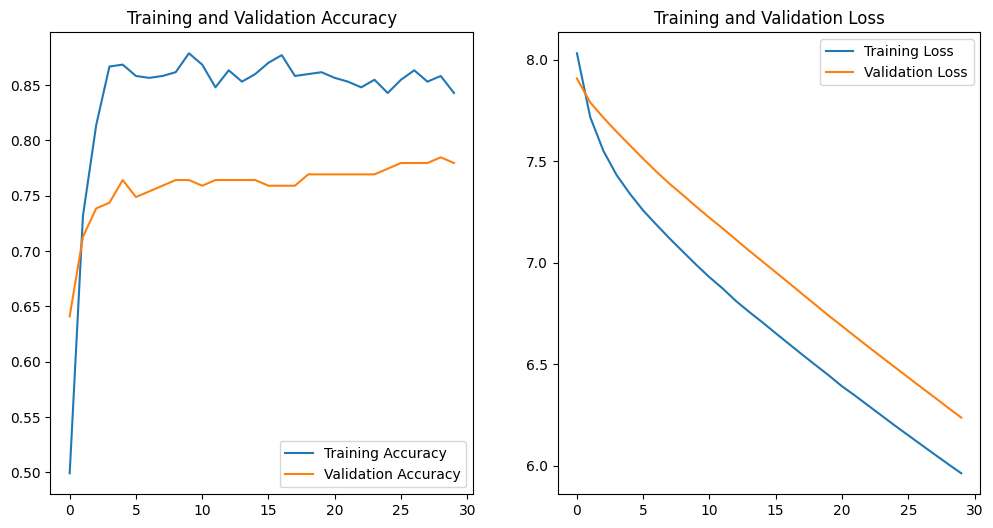

7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 212ms/step - accuracy: 0.7998 - loss: 6.2010
Testing Loss: 6.203865051269531, Testing Accuracy: 0.8051282167434692


In [16]:
class_weight = {0: 0.85, 1: 1.2, 2: 1.2}  # Sesuaikan bobot berdasarkan kinerja kelas

# Melatih model dan mencatat hasil pelatihan dalam objek `history`
history = model.fit(
    ds_train,
    validation_data=ds_val,
    epochs=30,
    class_weight=class_weight,
    callbacks=[early_stopping, reduce_lr]
)

# Menampilkan metrik dengan matplotlib
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(accuracy))

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, accuracy, label='Training Accuracy')
plt.plot(epochs_range, val_accuracy, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# Evaluasi model pada data testing
loss, accuracy = model.evaluate(ds_test)
print(f'Testing Loss: {loss}, Testing Accuracy: {accuracy}')


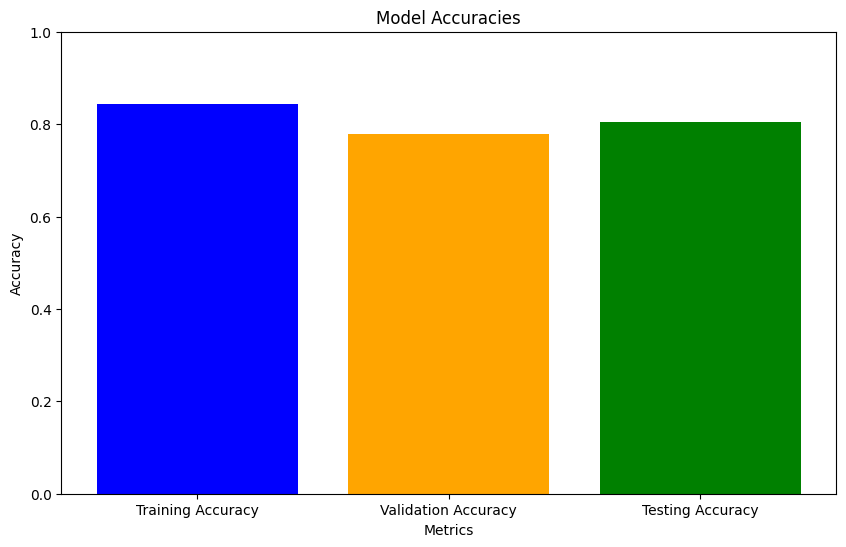

In [17]:
# Ambil nilai akurasi pada epoch terakhir
final_train_accuracy = history.history['accuracy'][-1]
final_val_accuracy = history.history['val_accuracy'][-1]

# Akurasi data testing (sudah didapat dari evaluasi model sebelumnya)
test_accuracy = accuracy

# Buat bar chart
labels = ['Training Accuracy', 'Validation Accuracy', 'Testing Accuracy']
accuracies = [final_train_accuracy, final_val_accuracy, test_accuracy]

plt.figure(figsize=(10, 6))
plt.bar(labels, accuracies, color=['blue', 'orange', 'green'])
plt.ylim(0, 1)  # Atur batas y dari 0 sampai 1
plt.xlabel('Metrics')
plt.ylabel('Accuracy')
plt.title('Model Accuracies')
plt.show()

## Importing Model (If Exist)

In [ ]:
from tensorflow.keras.models import load_model

# load model from .h5 file
model = load_model('models/skin_conditions_model.h5')

7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 325ms/step


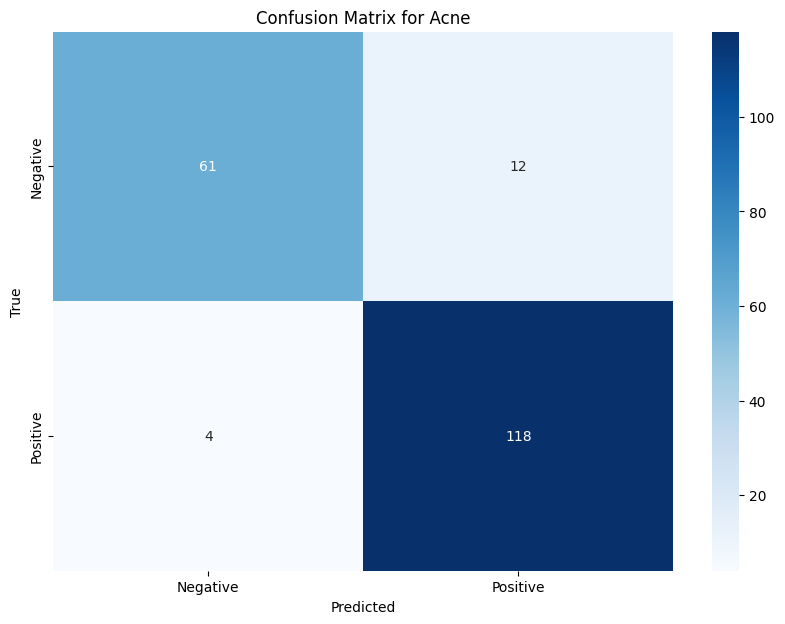

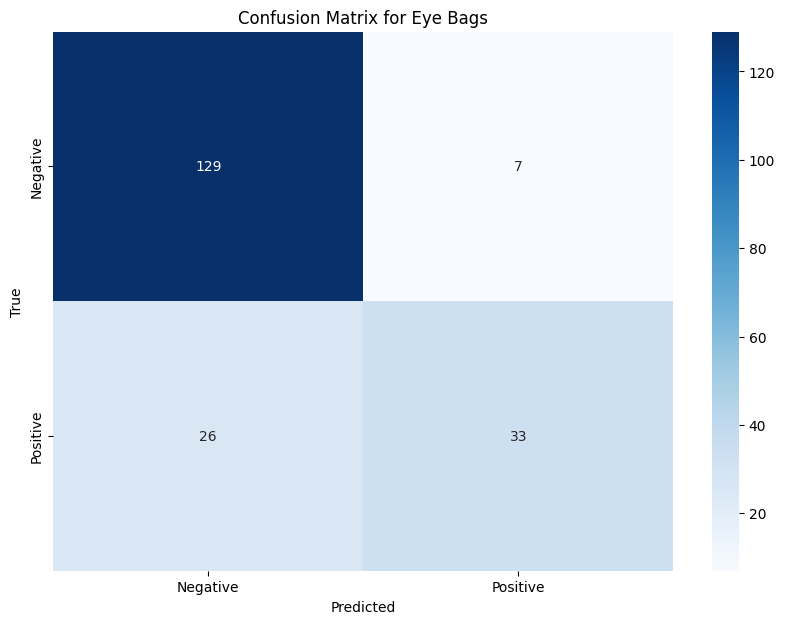

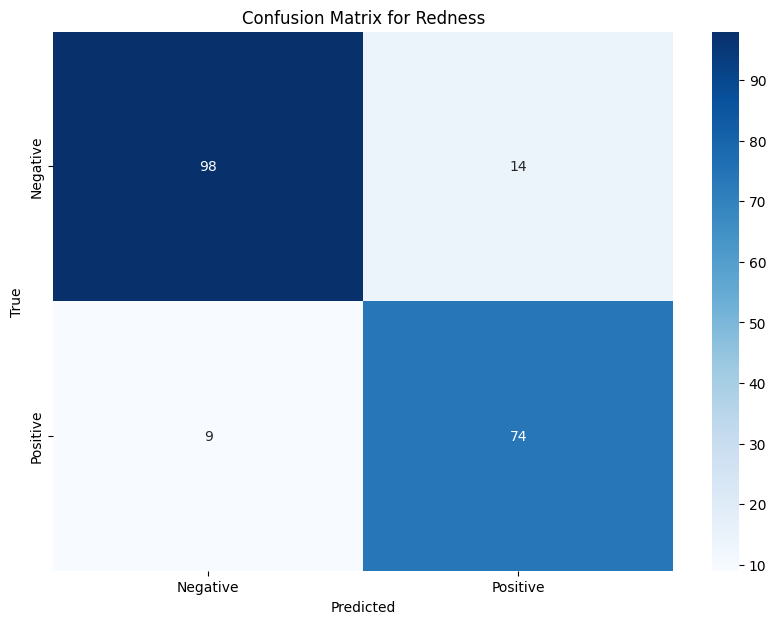

              precision    recall  f1-score   support

        Acne       0.91      0.97      0.94       122
    Eye Bags       0.82      0.56      0.67        59
     Redness       0.84      0.89      0.87        83

   micro avg       0.87      0.85      0.86       264
   macro avg       0.86      0.81      0.82       264
weighted avg       0.87      0.85      0.85       264
 samples avg       0.87      0.86      0.85       264



c:\Users\albia\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [18]:
# Membuat prediksi pada data testing
y_pred = model.predict(ds_test)
y_pred_binary = (y_pred > 0.5).astype(int)  # Mengubah prediksi menjadi biner

# Mendapatkan label aktual
y_true = np.concatenate([y for x, y in ds_test], axis=0)

# Menghitung multilabel confusion matrix
cm = multilabel_confusion_matrix(y_true, y_pred_binary)

# Menampilkan confusion matrix untuk masing-masing label
labels = ['Acne', 'Eye Bags', 'Redness']
for i, label in enumerate(labels):
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm[i], annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f'Confusion Matrix for {label}')
    plt.show()

# Menampilkan laporan klasifikasi
print(classification_report(y_true, y_pred_binary, target_names=labels))


In [ ]:
# Saving the model in .h5 format
model.save('models/skin_conditions_model.h5')